## Python Notebook to interact with gym-battery and battery-agent

This python notebook is a working document to interact with and test the environment and the agent.

Note: In order for this to work, gym-battery needs to be installed as a package, using pip install -e gym-battery from wherever gym-battery exists.

The ipython notebook should exist in battery dispatch by default and should be ableto access those resources so it does not necessarily need to be build/installed using pip.

In [1]:
import gym
import gym_battery 
import numpy as np
import pandas as pd

In [2]:
env = gym.make('gym_battery:battery-v0', **{'N_actions':5})
env.set_standard_system()

setting the standard system, A10S Med busines large usage with a 2,000kW/10,000kWh battery


In [3]:
# Drop partial day one and add a low-load period for 2 hours at the start of each episode
import datetime
env.load.DF = env.load.DF[76:76+31*96]
env.load.DF.value = [min(2800., r.value) if r.start.time() < datetime.time(2,0,0) else r.value for ix, r in env.load.DF.iterrows()]

In [4]:
env.load.DF.to_clipboard()

In [5]:
env.fit_load_to_space()
env.episode_type = 'count_days'
env.run_N_episodes = 30

In [6]:
# Show the possible action mapping the agent can take
env.action_mapping

{0: -1000.0, 1: -500.0, 2: 0.0, 3: 500.0, 4: 1000.0}

In [7]:
print(env.observation_space.low)
print("to")
print(env.observation_space.high)

[  0.   0. 600. 600.]
to
[   24. 10000.  5700.  6700.]


In [8]:
# Get the do-nothing value for taking no action
def dict_key_by_val(d, val):
    for k in d.keys():
        if d[k] == val:
            return k
    raise ValueError("value not found in dictionary")
    
act0 = dict_key_by_val(env.action_mapping, 0)
act0

2

In [9]:
''' Set up the agent and the discretizer.'''
from batterydispatch.agent.agents import DynaQAgent
from batterydispatch.agent.discretizers import Box_Discretizer

from batterydispatch.agent.policies import do_nothing
agent = DynaQAgent()
agent.set_policy(do_nothing, {'do_nothing_action': act0})

# Note, you can change the size of the state sapce by changing the number of buckets, below
agent.set_discretizer(Box_Discretizer(env.observation_space, N=[6, 4, 12, 12]))
agent.actions = env.action_space
agent.learning_rate = 0.05 # used for the updates of the Q estimates
agent.subtype = 'on-policy' # Setup the MC agent for off-policy learning

global eps
eps=0

remember to set self.actions = env.action_space!


In [10]:
agent.discretizer.buckets


[array([ 4.,  8., 12., 16., 20., 24.]),
 array([ 2500.25,  5000.5 ,  7500.75, 10001.  ]),
 array([1025.08333333, 1450.16666667, 1875.25      , 2300.33333333,
        2725.41666667, 3150.5       , 3575.58333333, 4000.66666667,
        4425.75      , 4850.83333333, 5275.91666667, 5701.        ]),
 array([1108.41666667, 1616.83333333, 2125.25      , 2633.66666667,
        3142.08333333, 3650.5       , 4158.91666667, 4667.33333333,
        5175.75      , 5684.16666667, 6192.58333333, 6701.        ])]

## Plot the day of data that we will be trying to learn from

c:\users\administrator\pycharmprojects\gym-battery\gym_battery\envs\battery_env.py:209: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  self.grid_flow.set_value(self.step_ix, 'state', tuple(self.state))


2011-03-07
96
-421123.08


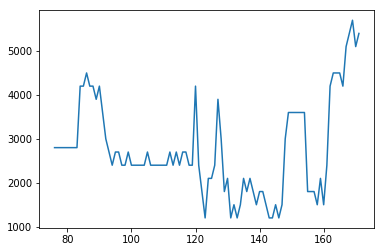

In [11]:

done = False
state = env.reset()
i = 0
while not done:
    i+=1
    _,reward,done, details = env.step(act0)

from matplotlib import pyplot as plt
plt.plot(env.grid_flow.net_flow)
try:
    print(list(env.grid_flow.start_date)[0])
except:
    pass
print(i)
print(reward)
default_reward = reward
plt.show()


In [12]:
# We then initialize the agent state-action estimates, based on the original billing period.
# We also give the do_nothing action a small bonus of 100, in order to prevent the agent from arbitrarily taking action.
agent.initialize_state_actions(new_default=default_reward,
                              do_nothing_action = act0,
                              do_nothing_bonus = 100)

In [13]:
agent.policy_args

{'do_nothing_action': 2}

## Set up the function to run the episodes, and run episodes until convergence.

In [14]:
from batterydispatch.agent.functions import log_history, run_episode

In [15]:
# We then set the final parameters guiding the episodes: The agents proclivity for random actions, 
# the number of episodes without a policy change before we can say we've converge.
agent.set_greedy_policy(eta=0.125)
agent.patience = 100
agent.planning_steps
agent.name

'DynaQ-Learning Agent'

In [16]:
agent.learning_rate = 0.075



In [18]:

from IPython.display import clear_output

for iteration in range(0, 30):
    notes = 'DONT USE; Run of a DynaQ agent on Stochastic Day with seeds, run for 10,000 episodes: Seed {}'.format(iteration)

    agent.set_greedy_policy(eta=0.1)
    starting_learning_rate = 0.075
    agent.planning_steps = 35
    agent.patience_counter = 0
    agent.initialize_state_actions(new_default=default_reward,
                              do_nothing_action = act0,
                              do_nothing_bonus = 100)    
    
    agent.set_seed(iteration)
    env.set_seed(iteration)
    
    i=30

    eps=0
    history = []
    while eps < 10001:
        i+=1
        eps+= 1

        if i>30:
            i=0
            clear_output()
            print(notes)
        print(eps, end=" | ")
        run_episode.run_episodes(env, agent, eps, history, default_reward, random_charge = False, run_type="once")
        agent.learning_rate = starting_learning_rate * np.exp(-0.0002*eps)
    
    agent.set_greedy_policy(eta=0)
    reward = run_episode.run_episodes(env, agent, eps, history, default_reward, random_charge=False, run_type='once')
    
    log_history.save_results(env, agent, history, reward, scenario = notes, agent_name=agent.name, notes='Iteration {}'.format(iteration))
    
    eps=0
    #history = []
    agent.learning_rate = 0
    agent.set_greedy_policy(0)
    while eps < 31:
        
        notes = 'CHECK: Run of a trained DynaQ agent on Stochastic Day: Seed {}, saving day {}'.format(iteration, eps)
        print(notes)
        
        i+=1
        eps+= 1

        print(eps, end=" | ")
        reward = run_episode.run_episodes(env, agent, eps, history, default_reward, random_charge = False, run_type="once")
    
        #agent.set_greedy_policy(eta=0)
    
        log_history.save_results(env, agent, history, reward, scenario = notes, agent_name=agent.name, notes='eps {}'.format(iteration))
            
        

DONT USE; Run of a DynaQ agent on Stochastic Day with seeds, run for 10,000 episodes: Seed 13
2636 | Current reward of -421123 / -421123, 5700.0 / 5700.0, patience=1
2637 | Current reward of -400475 / -403427, 5600.0 / 5700.0, patience=1
2638 | Current reward of -391169 / -391169, 5400.0 / 5400.0, patience=1
2639 | Current reward of -423763 / -401353, 6700.0 / 5700.0, patience=1
2640 | Current reward of -403731 / -382050, 6100.0 / 5700.0, patience=1
2641 | Current reward of -396472 / -392357, 4400.0 / 4200.0, patience=1
2642 | Current reward of -379472 / -369334, 4400.0 / 4500.0, patience=1
2643 | Current reward of -401107 / -395325, 5600.0 / 5400.0, patience=1
2644 | Current reward of -395479 / -394931, 5700.0 / 5700.0, patience=1
2645 | Current reward of -372905 / -373641, 5100.0 / 5100.0, patience=1
2646 | Current reward of -391864 / -392601, 5400.0 / 5400.0, patience=1
2647 | Current reward of -399863 / -387697, 5400.0 / 5400.0, patience=1
2648 | Current reward of -357987 / -336974

KeyboardInterrupt: 

In [ ]:
reward = run_episode.run_episodes(env, agent, eps, history, default_reward, random_charge=False, run_type='once')
reward

In [ ]:
log_history.save_results(env, agent, history, reward, scenario = notes, agent_name=agent.name, notes='Iteration {}'.format(iteration))


In [ ]:
from matplotlib import pyplot as plt
plt.plot(np.exp(-0.0002*np.arange(0,10000))*0.075)
plt.show()

In [ ]:
agent.history

In [ ]:
Qs = pd.DataFrame.from_dict(agent.S_A_values, orient='index')
Qs.to_clipboard()

In [ ]:
counts = pd.DataFrame.from_dict(agent.S_A_frequency, orient='index')
counts.to_clipboard


In [ ]:
print(f"The agent converged after {eps} episodes")

Agent has taken between 10 and 30 minutes, and between 700 and 2262 episodes, to converge on day 1. Optimal policy:
Current reward of -397414.125 / -406791.825, 5600.0 / 6000.0, patience=21

For 2 days, agent took 5 hours 8 minutes, and converged after 21200 episodes.

## Then we allow the agent to take entirely greedy actions and run the algorithm to see how much the agent learned. 

In [ ]:
agent.set_greedy_policy(eta=0)
    
state = env.reset(random_charge=False)
done = False
while not done:
    action = agent.get_action(state, list(env.action_mapping.keys()), 0.25)
    #print(state)
    #action = int(input("action:"))

    #print(action)
    state, reward, done, details = env.step(action)

try:
    new_demand = max(env.grid_flow.net_flow)
    orig_demand = max(env.grid_flow.load)
except AttributeError:
    new_demand = "???"
    orig_demand = "???"
    
    env.grid_flow['final_reward'] = reward
    env.grid_flow['original_reward'] = default_reward


print(f"Current reward of {reward} / {default_reward}, {new_demand} / {orig_demand}, patience={agent.patience_counter}")




In [ ]:
DF = save_results(scenario='Day1_load', agent_name='DynaQ', notes="ran the DynaQ agent again on the Day1 data, for a second (same agent)")

In [ ]:
pd.to_datetime(DF.saved_timestamp)

In [ ]:
sum(DF.index.duplicated())